**CS3MIR Lab 6 - Page Rank and HITS Algorithm**

In this lab, you will look at the Pagerank algorithm for ranking a collection of inter-linked web pages.
The following graph depicts a set of seven pages denoted by q0 to q6. Arcs are annotated with the word that occurs in the anchor text of the corresponding link.

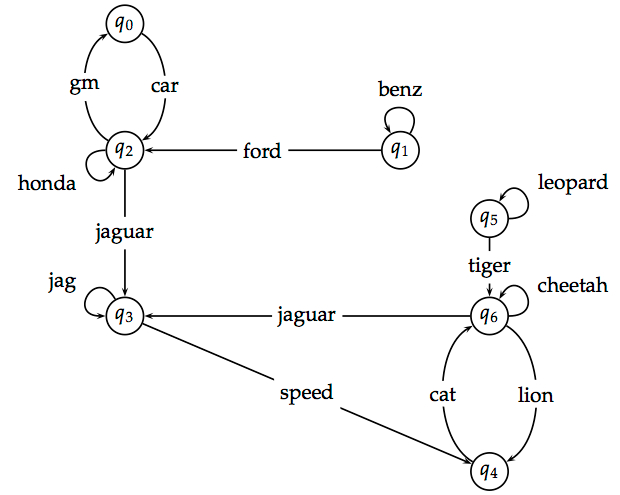

Based on the anchor text, what do you think each page is about? For example, given that the links to q3 are anchored with jag, jaguar, jaguar it is fair to assume that q3 probably refers to jaguars (either the cars or the animals).


In [1]:
from random import choice, random
from collections import Counter
import numpy as np

**The Random Surfer**

Under the random surfer model we imagine a user that is browsing the web, and at every time instance randomly clicks on a link on the current page. We can optionally assume a teleporting mechanism which teleports the user to any random page with a probability α.

Let's create set of pairs of pages, to denote the edges. The vertices and edges arrays encodes the graph provided above:

In [2]:
vertices=[0,1,2,3,4,5,6]
edges={(0,2),(1,1),(1,2),(2,0),(2,2),(2,3),(3,3),(3,4),(4,6),(5,5),(5,6),(6,6),(6,3),(6,4)}

Write the function adjecant vertices (adjVertice) which takes vertice v as input and returns the list of connected vertices. For example, if vertice (2) is passed as input, the function should return 0,1,2,3 

Let's create a function called randomwalk that takes as input the set edges, a teleport probability a and a positive integer iters and performs the randomwalk. Starting from any page, the function will randomly follow links from one page to the next, teleporting to a completely random page with probability a at each iteration.

The function first randomly selects a starting vertex x from the set of vertices. Then, for each iteration, it randomly chooses between two actions:

1. With probability a, the function selects a new vertex at random (i.e., "teleports" to a random vertex).

2. With probability 1-a, the function randomly selects one of the outlinks from the current vertex and moves to that vertex.
The function returns a generator that yields the vertex visited at each step of the random walk.

The last line of code, next(X), calls the next() function on the generator object X, which retrieves the next value (i.e., the next vertex visited in the random walk) from the generator.



In [3]:
def randomwalk(edges,vertices,a,iters):
  x = choice(vertices)
  #print(x)
  for i in range(iters):
    if random()<a:
      # with a probability a the random walk will pick a random vertex to␣ visit (teleporting)
      x = choice(vertices)
    else:
      #otherwise it will pick at random one of the outlinks from the␣ current vertex
      x = choice([v for (u,v) in edges if u==x])
    yield x

In [4]:
X = randomwalk(edges, vertices, 0.05, 10)
next(X)

4

Now, let's create a function called generatehistogram to call the randomwalk function and store all visited states and eventually create a histogram of the frequency by which each page was visited. The generatehistogram function returns the histogram.

In [5]:
def pagerank1_generatehistogram(edges,vertices,a,iters):
  # This is a very concise way to create a histogram of the random walk sequence using a Counter object
  hist = Counter(randomwalk(edges, vertices,a, iters))
  
  # The bin counts in the histogram are normalized so that they all sum to␣one. Meaning that we can treat them as probabilities.
  return {v:hist[v]/iters for v in vertices}

We can now use the following code to sample a series of random walks of varying lengths.

In [6]:
p1 = pagerank1_generatehistogram(edges,vertices, 0.2, 10)
p2 = pagerank1_generatehistogram(edges,vertices, 0.2, 100)
p3 = pagerank1_generatehistogram(edges,vertices, 0.2, 1000)
p4 = pagerank1_generatehistogram(edges,vertices, 0.2, 10000)
p5 = pagerank1_generatehistogram(edges,vertices, 0.2, 100000)

print(p1)
print(p2)
print(p3)
print(p4)
print(p5)


{0: 0.2, 1: 0.1, 2: 0.5, 3: 0.2, 4: 0.0, 5: 0.0, 6: 0.0}
{0: 0.04, 1: 0.01, 2: 0.08, 3: 0.18, 4: 0.24, 5: 0.07, 6: 0.38}
{0: 0.051, 1: 0.034, 2: 0.106, 3: 0.244, 4: 0.213, 5: 0.048, 6: 0.304}
{0: 0.0659, 1: 0.0507, 2: 0.1342, 3: 0.2352, 4: 0.1939, 5: 0.0477, 6: 0.2724}
{0: 0.06482, 1: 0.04861, 2: 0.13497, 3: 0.23044, 4: 0.19441, 5: 0.04911, 6: 0.27764}


Let's plot to verify that the frequencies of the visits are indeed converging to a fixed probability distribution which is the “steady state visit rate”

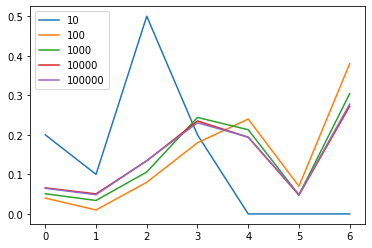

In [7]:
import matplotlib.pyplot as plt
plt.plot(vertices, [p1[p] for p in vertices],  label="10")
plt.plot(vertices, [p2[p] for p in vertices],  label="100")
plt.plot(vertices, [p3[p] for p in vertices],  label="1000")
plt.plot(vertices, [p4[p] for p in vertices],  label="10000")
plt.plot(vertices, [p5[p] for p in vertices],  label="100000")
plt.legend()

Modify the randomwalk function name it as randomwalkdesc, instead of randomly follow links from one page to the next and teleporting to a completely random page with probability a at each iteration, your modified randomwalk function should select the vertice to be visited based on decending order - e.g. if the adjacent vertices of vertice (2) are 0,2,3, your function should select 3 to visit.  

Generate histogram similar to 'generatehistogram' by calling the randomwalkdesc function and create a histogram of the frequency by which each page was visited and plot to verify the frequencies.

**HITS Algorithm** 

For the HITS Algorithm we are using a different approach. We will first implemet the Node and the Graph Class

In [8]:
import numpy as np


class Node:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parents = []
        self.auth = 1.0
        self.hub = 1.0

    def link_child(self, new_child):
        for child in self.children:
            if(child.name == new_child.name):
                return None
        self.children.append(new_child)

    def link_parent(self, new_parent):
        for parent in self.parents:
            if(parent.name == new_parent.name):
                return None
        self.parents.append(new_parent)

    def update_auth(self):
        self.auth = sum(node.hub for node in self.parents)

    def update_hub(self):
        self.hub = sum(node.auth for node in self.children)


class Graph:
    def __init__(self):
        self.nodes = []

    def contains(self, name):
        for node in self.nodes:
            if(node.name == name):
                return True
        return False

    # Return the node with the name, create and return new node if not found
    def find(self, name):
        if(not self.contains(name)):
            new_node = Node(name)
            self.nodes.append(new_node)
            return new_node
        else:
            return next(node for node in self.nodes if node.name == name)

    def add_edge(self, parent, child):
        parent_node = self.find(parent)
        child_node = self.find(child)

        parent_node.link_child(child_node)
        child_node.link_parent(parent_node)

    def display(self):
        for node in self.nodes:
            print(f'{node.name} links to {[child.name for child in node.children]}')

    def sort_nodes(self):
        self.nodes.sort(key=lambda node: int(node.name))

    def display_hub_auth(self):
        for node in self.nodes:
            print(f'{node.name}  Auth: {node.old_auth}  Hub: {node.old_hub}')

    def normalize_auth_hub(self):
        auth_sum = sum(node.auth for node in self.nodes)
        hub_sum = sum(node.hub for node in self.nodes)

        for node in self.nodes:
            node.auth /= auth_sum
            node.hub /= hub_sum

    def get_auth_hub_list(self):
        auth_list = np.asarray([node.auth for node in self.nodes], dtype='float32')
        hub_list = np.asarray([node.hub for node in self.nodes], dtype='float32')

        return np.round(auth_list, 3), np.round(hub_list, 3)

Let's use this function to initialise the graph

In [9]:
def init_graph(edges):

    graph = Graph()

    for parent,child in edges:
        graph.add_edge(parent, child)

    graph.sort_nodes()

    return graph

Now, Let's implement the HITS Algorithm

In [10]:
def HITS_one_iter(graph):
    node_list = graph.nodes

    for node in node_list:
        node.update_auth()

    for node in node_list:
        node.update_hub()

    graph.normalize_auth_hub()


def HITS(graph, iteration=100):
    for i in range(iteration):
        HITS_one_iter(graph)

Let's initialise the graph and execute it for 5 iterations

In [11]:

graph = init_graph(edges)
HITS(graph, 5)
auth_list, hub_list = graph.get_auth_hub_list()
print()
print('Authority:')
print(auth_list)
   
print('Hub:')
print(hub_list)
print()



Authority:
[0.094 0.034 0.155 0.293 0.199 0.039 0.187]
Hub:
[0.063 0.076 0.219 0.199 0.076 0.092 0.275]



Similary in the following cells, execute the HITS algorithms for 10, 100 and 1000 iterations. What do you observe?